# NESTML Ornstein-Uhlenbeck noise tutorial

In this tutorial, we will formulate the Ornstein-Uhlenbeck (O-U) noise process in NESTML and simulate it in NEST Simulator.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

## The Ornstein-Uhlenbeck process

The Ornstein-Uhlenbeck process is often used as a source of noise because it is well understood and has convenient properties (it is a Gaussian process, has the Markov property, and is stationary). Let the O-U process, denoted $U(t)$ (with $t\geq 0$) , be defined as the solution of the following stochastic differential equation:

\begin{align}
\frac{dU}{dt} = \frac{\mu - U}{\tau} + \sigma\sqrt{\frac 2 \tau} \frac{dB(t)}{dt}
\end{align}

The first right-hand side term is a "drift" term which is deterministic and slowly reverts $U_t$ to the mean $\mu$, with time constant $\tau$. The second term is stochastic as $B(t)$ is the Brownian motion (also "Wiener") process, and $\sigma>0$ is the standard deviation of the noise.

It turns out that the infinitesimal step in Brownian motion is white noise, that is, an independent and identically distributed sequence of Gaussian $\mathcal{N}(0, 1)$ random variables. The noise $dB(t)/dt$ can be sampled at time $t$ by drawing a sample from that Gaussian distribution, so if the process is sampled at discrete intervals of length $h$, we can write (equation 2.47 from [\[1\]](#References)):

\begin{align}
U(t + h) = \mu + (U(t) - \mu)\exp(-h/\tau) + \sigma\sqrt{(1 - \exp(-2h / \tau ))} \cdot\mathcal{N}(0, 1)
\end{align}

## Simulating the Ornstein-Uhlenbeck process with NESTML

### Formulating the model in NESTML

The O-U process is now defined as a stepwise update equation, that is carried out at each timestep. All statements contained in the NESTML ``update`` block are run at every timestep, so this is a natural place to place the O-U updates.

Updating the O-U process state requires knowledge about how much time has elapsed. As we will update the process once every simulation timestep, we pass this value by invoking the ``resolution()`` function.

In [2]:
nestml_ou_model = '''
neuron ornstein_uhlenbeck_noise:

    parameters:
        mean_noise real = 500    # mean of the noise
        sigma_noise real = 50    # std. dev. of the noise
        tau_noise ms = 20 ms     # time constant of the noise

    internals:
        A_noise real = sigma_noise * ((1 - exp(-2 * resolution() / tau_noise)))**.5

    state:
        U real = mean_noise   # set the initial condition

    update:
        U = mean_noise \
          + (U - mean_noise) * exp(-resolution() / tau_noise) \
          + A_noise * random_normal(0, 1)
'''

Save to a temporary file and make the model available to instantiate in NEST:

In [3]:
# generate and build code
module_name, neuron_model_name_adapt_curr = \
    NESTCodeGeneratorUtils.generate_code_for(nestml_ou_model)

# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)

[6,ornstein_uhlenbeck_noisea0ddeae3e8dd4f9ba89af92d5cee45f1_nestml, WARNING, [2:0;16:0]]: Input block not defined!
[7,ornstein_uhlenbeck_noisea0ddeae3e8dd4f9ba89af92d5cee45f1_nestml, WARNING, [2:0;16:0]]: Output block not defined!
[16,ornstein_uhlenbeck_noisea0ddeae3e8dd4f9ba89af92d5cee45f1_nestml, WARNING, [2:0;16:0]]: Input block not defined!
[17,ornstein_uhlenbeck_noisea0ddeae3e8dd4f9ba89af92d5cee45f1_nestml, WARNING, [2:0;16:0]]: Output block not defined!


### Running the simulation in NEST

Let's define a function that will instantiate and set parameters for the O-U model, run a simulation, and plot and return the results.

In [4]:
def evaluate_ou_process(neuron_model_name: str, h: float=.1, t_sim:float=100., neuron_parms=None, title=None, plot=True):
    """
    h : float
        timestep in ms
    t_sim : float
        total simulation time in ms
    """
    nest.ResetKernel()
    nest.SetKernelStatus({"resolution": h})
    neuron = nest.Create(neuron_model_name)

    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)
            
    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["U"],
                    "interval": h})
    nest.Connect(multimeter, neuron)
    
    nest.Simulate(t_sim)

    dmm = nest.GetStatus(multimeter)[0]
    U = dmm["events"]["U"]
    timevec = dmm["events"]["times"]
    
    if plot:
        fig, ax = plt.subplots(figsize=(12., 5.))
        if title is not None:
            fig.suptitle(title)
        ax.plot(timevec, U)
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("U")
        ax.set_xlim(0., t_sim)
        ax.grid()
    
    return timevec, U

Then, we can run the process. Hint: play with the parameters a bit here and see the effects it has on the returned timeseries.

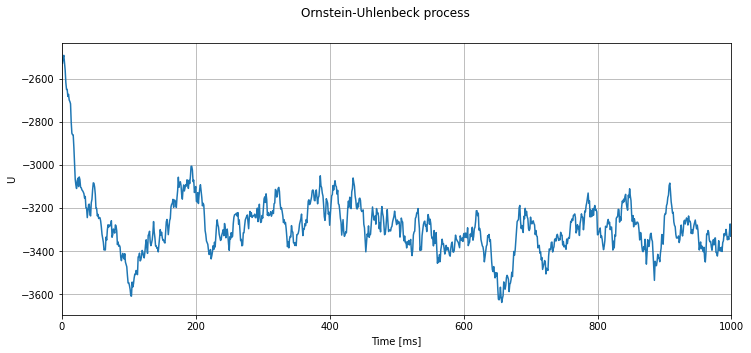

In [5]:
timevec, U = evaluate_ou_process(neuron_model_name_adapt_curr,
                                 h=1.,
                                 t_sim=1000.,
                                 neuron_parms={"U" : -2500.,
                                               "mean_noise": -3333.,
                                               "tau_noise": 20.,
                                               "sigma_noise": 100.},
                                title=r"Ornstein-Uhlenbeck process")

### Correctness test based on predicting variance

Assuming that the initial value of the process is picked equal to the process mean, we can predict the variance of the timeseries as ([\[1\]](#References), eq. 2.26):
    
\begin{align}
\text{Var}(U) = \sigma^2
\end{align}

We now run a consistency check across parameters, to make sure that the prediction matches the result derived from the timeseries generated by sampling the process.

In [6]:
h = [.01, .1, 1.]
tau_noise = [10., 100., 1000.]
sigma_noise = [0., 10., 100., 1000.]

max_rel_error = .25   # yes, this is pretty terrible!
                      # Need a very long integration time (esp. for large tau)
                      # to get a tighter bound.

for _h in h:
    for _tau_noise in tau_noise:
        for _sigma_noise in sigma_noise:
            print("For h = " + str(_h) + ", tau_noise = " + str(_tau_noise) + ", sigma_noise = " + str(_sigma_noise))
            c = (_sigma_noise * np.sqrt(2 / _tau_noise))**2
            timevec, U = evaluate_ou_process(neuron_model_name_adapt_curr,
                                             h=_h,
                                             t_sim=25000.,
                                             neuron_parms={"U" : 0.,
                                                           "mean_noise": 0.,
                                                           "tau_noise": _tau_noise,
                                                           "sigma_noise": _sigma_noise},
                                            title=r"Ornstein-Uhlenbeck process ($\tau$=" + str(_tau_noise) + ", $\sigma$=" + str(_sigma_noise) + ")",
                                            plot=False)
            var_actual = np.var(U)
            print("Actual variance: " + str(var_actual))
            var_expected = _sigma_noise**2
            print("Expected variance: " + str(var_expected))
            if var_actual < 1E-15:
                assert var_expected < 1E-15
            else:
                assert np.abs(var_expected - var_actual) / (var_expected + var_actual) < max_rel_error

For h = 0.01, tau_noise = 10.0, sigma_noise = 0.0
Actual variance: 0.0
Expected variance: 0.0
For h = 0.01, tau_noise = 10.0, sigma_noise = 10.0
Actual variance: 102.20988990712311
Expected variance: 100.0
For h = 0.01, tau_noise = 10.0, sigma_noise = 100.0
Actual variance: 10220.988990712309
Expected variance: 10000.0
For h = 0.01, tau_noise = 10.0, sigma_noise = 1000.0
Actual variance: 1022098.8990712308
Expected variance: 1000000.0
For h = 0.01, tau_noise = 100.0, sigma_noise = 0.0
Actual variance: 0.0
Expected variance: 0.0
For h = 0.01, tau_noise = 100.0, sigma_noise = 10.0
Actual variance: 114.93711386061999
Expected variance: 100.0
For h = 0.01, tau_noise = 100.0, sigma_noise = 100.0
Actual variance: 11493.711386061985
Expected variance: 10000.0
For h = 0.01, tau_noise = 100.0, sigma_noise = 1000.0
Actual variance: 1149371.1386062026
Expected variance: 1000000.0
For h = 0.01, tau_noise = 1000.0, sigma_noise = 0.0
Actual variance: 0.0
Expected variance: 0.0
For h = 0.01, tau_nois

### Autocorrelogram

If we plot the autocorrelogram, we should find high correlations only for lags lower than $\tau$.

Let's look at a process with $\tau=1000$:

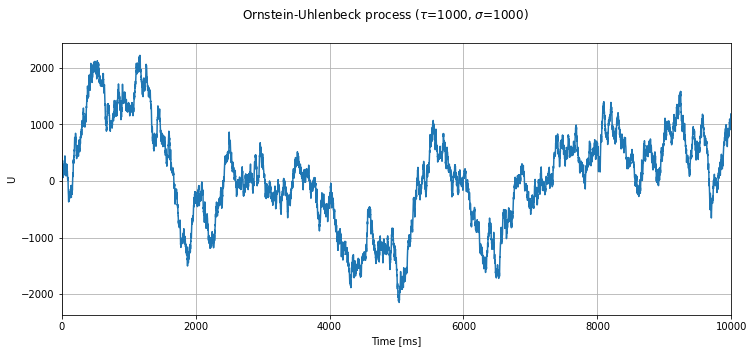

In [7]:
timevec, U = evaluate_ou_process(neuron_model_name_adapt_curr,
                                 h=_h,
                                 t_sim=10000.,
                                 neuron_parms={"U" : 0.,
                                               "mean_noise": 0.,
                                               "tau_noise": 1000.,
                                               "sigma_noise": 1000.},
                                 title=r"Ornstein-Uhlenbeck process ($\tau$=1000, $\sigma$=1000)")

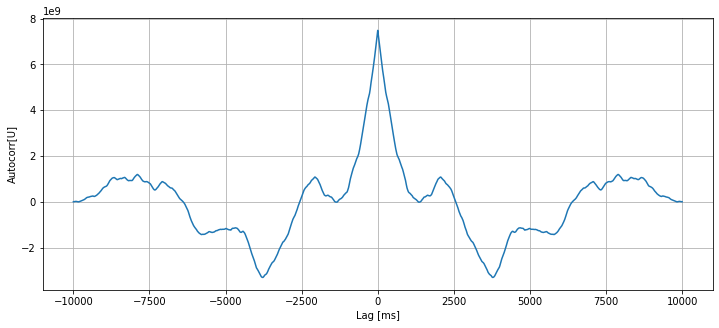

In [8]:
def autocorr(x):
    return np.correlate(x, x, mode='full')

fig, ax = plt.subplots(figsize=(12., 5.))
U_autocorr = autocorr(U)
lags = np.arange(len(U_autocorr)) - len(U_autocorr) / 2
ax.plot(lags, U_autocorr)
ax.set_xlabel("Lag [ms]")
ax.set_ylabel("Autocorr[U]")
ax.grid()

## Integrating Ornstein-Uhlenbeck noise into a NESTML integrate-and-fire neuron

Now, the O-U noise process is integrated into an existing NESTML model, as an extra somatic current $I_{noise}$. In this example, we use the integrate-and-fire neuron with current based synapses and an exponentially shaped synaptic kernel, and no refractoriness mechanism.

This neuron can be written in just a few lines of NESTML:


In [9]:
nestml_iaf_psc_exp_model = '''
neuron iaf_psc_exp:

    state:
        V_m mV = E_L
        I_noise pA = mean_noise

    equations:
        kernel psc_kernel = exp(-t / tau_syn)
        V_m' = -(V_m - E_L) / tau_m + (convolve(psc_kernel, spikes) + I_e + I_noise) / C_m

    parameters:
        E_L mV = -65 mV      # resting potential
        I_e pA = 0 pA        # constant external input current
        tau_m ms = 25 ms     # membrane time constant
        tau_syn ms = 5 ms    # synaptic time constant
        C_m pF = 250 pF        # membrane capacitance
        V_theta mV = -30 mV  # threshold potential
        mean_noise pA = 0.057 pA       # mean of the noise current
        sigma_noise pA = 0.003 pA      # standard deviation of the noise current
        tau_noise ms = 10 ms              # time constant of the noise process

    internals:
        A_noise real = sigma_noise * ((1 - exp(-2 * resolution() / tau_noise)))**.5

    input:
        spikes pA <- spike

    output:
        spike

    update:
        I_noise = mean_noise \
                  + (I_noise - mean_noise) * exp(-resolution() / tau_noise) \
                  + A_noise * random_normal(0, 1)
              
        integrate_odes()
    
        if V_m > V_theta:
            V_m = E_L
            emit_spike()
'''

In [10]:
# generate and build code
module_name, neuron_model_name = \
    NESTCodeGeneratorUtils.generate_code_for(nestml_iaf_psc_exp_model)

# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)

[10,iaf_psc_exp2571d1ed647c4757a4de5a2216df1662_nestml, WARNING, [33:18;33:103]]: Implicit casting from (compatible) type 'pA' to 'real'.


Now, the NESTML model is ready to be used in a simulation.

In [11]:
def evaluate_neuron(neuron_name, neuron_parms=None, I_e=0.,
                    mu=0., sigma=0., t_sim=300., plot=True):
    """
    Run a simulation in NEST for the specified neuron. Inject a stepwise
    current and plot the membrane potential dynamics and spikes generated.
    """
    dt = .1   # [ms]

    nest.ResetKernel()
    try:
        nest.Install("nestml_iaf_module")
    except :
        pass
    neuron = nest.Create(neuron_name)
    if neuron_parms:
        for k, v in neuron_parms.items():
            nest.SetStatus(neuron, k, v)
    nest.SetStatus(neuron, "I_e", I_e)
    nest.SetStatus(neuron, "mean_noise", mu)
    nest.SetStatus(neuron, "sigma_noise", sigma)
    
    multimeter = nest.Create("multimeter")
    multimeter.set({"record_from": ["V_m"],
                    "interval": dt})
    sr = nest.Create("spike_recorder")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, sr)
    
    nest.Simulate(t_sim)

    dmm = nest.GetStatus(multimeter)[0]
    Voltages = dmm["events"]["V_m"]
    tv = dmm["events"]["times"]
    dSD = nest.GetStatus(sr, keys='events')[0]
    spikes = dSD['senders']
    ts = dSD["times"]
    
    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(tv, Voltages)
        ax.scatter(ts, V_m_at_spike_times)
        ax.set_xlabel("Time [ms]")
        ax.set_ylabel("V_m [mV]")
        ax.grid()

    return ts

If we stimulate the neuron with a constant current of 300 pA alone, it does not spike:

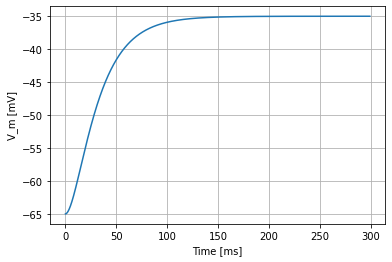

In [12]:
spike_times = evaluate_neuron(neuron_model_name, mu=300, sigma=0.)

However, for the same $\mu$=300 pA, but setting $\sigma$=200 pA/√ms, the effect of the noise can be clearly seen in the membrane potential, and the occasional spiking of the neuron:


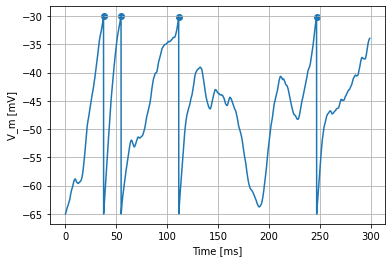

In [13]:
spike_times = evaluate_neuron(neuron_model_name, mu=300, sigma=200)
assert spike_times.size > 0

To further quantify the effects of the noise, we can plot a distribution of interspike intervals:

265 spikes recorded
Mean ISI: 94.38257575757575
ISI std. dev.: 88.84117979123644


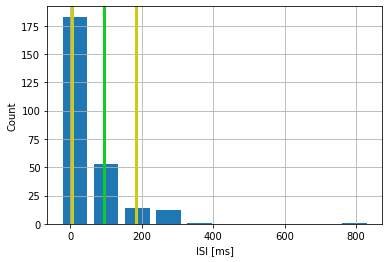

In [14]:
spike_times = evaluate_neuron(neuron_model_name,
                              mu=300,
                              sigma=200,
                              t_sim=25000.,
                              plot=False)

ISI = np.diff(spike_times)
assert ISI.size > 0

ISI_mean = np.mean(ISI)
ISI_std = np.std(ISI)

print(str(len(spike_times)) + " spikes recorded")
print("Mean ISI: " + str(ISI_mean))
print("ISI std. dev.: " + str(ISI_std))

count, bin_edges = np.histogram(ISI)

fig, ax = plt.subplots()
ax.bar(bin_edges[:-1], count, width=.8 * (bin_edges[1] - bin_edges[0]))
ylim = ax.get_ylim()
ax.plot([ISI_mean, ISI_mean], ax.get_ylim(), c="#11CC22", linewidth=3)
ax.plot([ISI_mean - ISI_std, ISI_mean - ISI_std], ylim, c="#CCCC11", linewidth=3)
ax.plot([ISI_mean + ISI_std, ISI_mean + ISI_std], ylim, c="#CCCC11", linewidth=3)
ax.set_ylim(ylim)
ax.set_xlabel("ISI [ms]")
ax.set_ylabel("Count")
ax.grid()

Further directions
----------

* Calculate and plot the time-varying expected variance of the OU process when its initial value is unequal to the process mean ([1], eq. 2.26; see Fig. 2 for a visual example)
* Make an extension of the neuron model, that stimulates the cell with an inhibitory as well as excitatory noise current.
* Instead of a current-based noise, make a neuron model that contains a conductance-based noise.

References
----------

[1] D.T. Gillespie, "The mathematics of Brownian motion and Johnson noise", Am. J. Phys. 64, 225 (1996); doi: 10.1119/1.18210











Acknowledgements
----------------

Thanks to Tobias Schulte to Brinke, Barna Zajzon, Renato Duarte, Claudia Bachmann and all participants of the CNS2020 tutorial on NEST Desktop & NESTML!

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).

License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.